In [1]:
import numpy as np
from scipy import stats
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
from venn import venn
import upsetplot
from statsmodels.stats.meta_analysis import combine_effects

from plotting import (savefig,
                      COLOR_I3D,
                      COLOR_LIT,
                      COLOR_Y2H,
                      COLOR_ALPHAFOLD_ROSETTAFOLD)
from datasets import (load_I3D_exp_24,
                      load_lit_bm_24,
                      load_Y2H_union_25,
                      load_sys_nb,
                      load_AlphaFold_RoseTTAFold,
                      load_PDB_metadata)

In [2]:
# the ipython matplotlib inline display overrides the rcParams
# that used to be called on the pyplot import but now seems like
# it's called on the first use of inline figures or something 
# problem is in ipython: https://github.com/ipython/ipython/issues/10383
# should be fixed soon: https://github.com/ipython/matplotlib-inline/pull/14
plt.show()
mpl.rcParams['font.size'] = 7.
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['savefig.dpi'] = 500

In [3]:
i3d = load_I3D_exp_24(remove_homodimers=True, include_date=True)
pdb_metadata = load_PDB_metadata(i3d['PDB_ID'].unique())
i3d['experimental_method'] = i3d['PDB_ID'].map(pdb_metadata['experimental_method'])
lit = load_lit_bm_24(remove_homodimers=True, include_date=True)
abbi = load_Y2H_union_25(remove_homodimers=True)
y2h_union = abbi.loc[abbi['Uetz-screen'] | abbi['Ito-core'] | abbi['CCSB-YI1'], :].copy()
afrf = load_AlphaFold_RoseTTAFold(remove_homodimers=True)
sysnb = load_sys_nb(remove_homodimers=True)
i3d_inc_homo = load_I3D_exp_24(remove_homodimers=False, include_date=True)
lit_inc_homo = load_lit_bm_24(remove_homodimers=False, include_date=True)
abbi_inc_homo = load_Y2H_union_25(remove_homodimers=False)
y2h_union_inc_homo = abbi_inc_homo.loc[abbi_inc_homo['Uetz-screen'] | 
                              abbi_inc_homo['Ito-core'] | 
                              abbi_inc_homo['CCSB-YI1'], :].copy()


NOTE: dropping 6 pairs with missing ORF names


In [4]:
print(i3d_inc_homo.shape[0] - i3d.shape[0], 'homodimer edges in I3D-exp-24')
print(lit_inc_homo.shape[0] - lit.shape[0], 'homodimer edges in Lit-BM-24')
print(abbi_inc_homo.shape[0] - abbi.shape[0], 'homodimer edges in Y2H-union-25')

612 homodimer edges in I3D-exp-24
590 homodimer edges in Lit-BM-24
249 homodimer edges in Y2H-union-25


In [5]:
# merge all four datasets
# add YeRI data
# check all have dates
uetz_date = np.datetime64('2000-02-01')
ito_date = np.datetime64('2001-04-10')
yu_date = np.datetime64('2008-10-03')
yeri_date = np.datetime64('2025-07-04')
afrf_date = np.datetime64('2021-11-11')

abbi.loc[abbi['date'].isnull(), 'date'] = yeri_date
afrf['date'] = afrf_date
lit['date'] = lit['date_bm']
i3d['pair'] = i3d['orf_name_a'] + '_' + i3d['orf_name_b']
if i3d['pair'].duplicated().any():
    raise UserWarning('unexpected duplicates')
i3d = i3d.set_index('pair')
ayc = pd.concat([lit.reset_index().copy(),
                afrf.reset_index().copy(),
                i3d.reset_index().copy(),
                abbi.reset_index().copy(),
                ])
# sort by date
ayc = ayc.sort_values('date').drop_duplicates(subset=['pair']).set_index('pair')
# drop_duplicates

In [6]:
ppis_b4_uetz = (ayc['date'] < uetz_date).sum()
ppis_b4_ito = (ayc['date'] < ito_date).sum()
ppis_b4_yu = (ayc['date'] < yu_date).sum()
ppis_b4_afrf = (ayc['date'] < afrf_date).sum()
ppis_b4_yeri = (ayc['date'] < yeri_date).sum()
uetz_novel = ((ayc['date'] == uetz_date) & (ayc['Uetz-screen'] == True)).sum()
ito_novel = ((ayc['date'] == ito_date) & (ayc['Ito-core'] == True)).sum()
yu_novel = ((ayc['date'] == yu_date) & (ayc['CCSB-YI1'] == True)).sum()
afrf_novel = ((ayc['date'] == afrf_date) & (ayc['PPI Score'].notnull())).sum()
yeri_novel = ((ayc['date'] == yeri_date) & (ayc['YeRI'] == True)).sum()

print(ppis_b4_uetz, 'PPIs the day before Uetz-screen')
print(uetz_novel, 'PPIs added by Uetz-screen', '+{:.1%}'.format((uetz_novel / ppis_b4_uetz)))
print(ppis_b4_ito, 'PPIs the day before Ito-core')
print(ito_novel, 'PPIs added by Ito-core ', '+{:.1%}'.format((ito_novel / ppis_b4_ito)))
print(ppis_b4_yu, 'PPIs the day before CCSB-YI1')
print(yu_novel, 'PPIs added by CCSB-YI1', '+{:.1%}'.format((yu_novel / ppis_b4_yu)))
print(ppis_b4_afrf, 'PPIs the day before AF/RF-core')
print(afrf_novel, 'PPIs added by AF/RF-core', '+{:.1%}'.format((afrf_novel / ppis_b4_afrf)))
print(ppis_b4_yeri, 'PPIs the day before YeRI')
print(yeri_novel, 'PPIs added by YeRI', '+{:.1%}'.format((yeri_novel / ppis_b4_yeri)))
print()
abbi_novel_total = uetz_novel + ito_novel + yu_novel + yeri_novel
print('Total added by four systematic binary:', abbi_novel_total,
      '+{:.1%}'.format(abbi_novel_total / (ayc.shape[0] - abbi_novel_total)))

494 PPIs the day before Uetz-screen
577 PPIs added by Uetz-screen +116.8%
1348 PPIs the day before Ito-core
598 PPIs added by Ito-core  +44.4%
3565 PPIs the day before CCSB-YI1
1251 PPIs added by CCSB-YI1 +35.1%
8896 PPIs the day before AF/RF-core
329 PPIs added by AF/RF-core +3.7%
10085 PPIs the day before YeRI
1517 PPIs added by YeRI +15.0%

Total added by four systematic binary: 3943 +51.5%


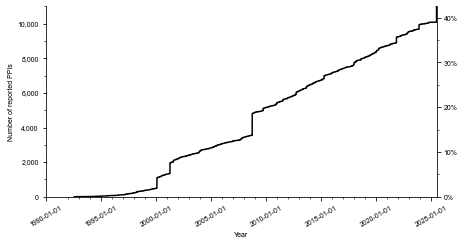

In [7]:
interactome_size = np.mean([19500, 28472, 18000, 37600])

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=7, h=3.5)

uetz_date = np.datetime64('2000-02-01')
ito_date = np.datetime64('2001-04-10')
yu_date = np.datetime64('2008-10-03')
yeri_date = np.datetime64('2025-07-04')
afrf_date = np.datetime64('2021-11-11')
n_uetz = abbi['Uetz-screen'].sum()
n_ito = (abbi['Uetz-screen'] | abbi['Ito-core']).sum()
n_yi1 = (abbi['Uetz-screen'] | abbi['Ito-core'] | abbi['CCSB-YI1']).sum()
n_yeri = load_Y2H_union_25(remove_homodimers=True).shape[0]
n_afrf = afrf.shape[0]
xlow = np.datetime64('1990')
xhigh = np.datetime64('2025-07-04')

ax.plot(sorted(ayc.loc[ayc['date'].notnull(), 'date'].values),
        range(1, ayc['date'].notnull().sum() + 1),
        color='black')

ax.set_xlim(xlow, xhigh)
ax.set_xlabel('Year')
ax.xaxis.set_tick_params(rotation=30)
ax.set_ylabel('Number of reported PPIs')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
arrow_length = 3000
ymax = 11000
ax.set_ylim(0., 11000)
ax.set_yticks(range(0, 11001, 2000))
ax.set_yticks(range(0, 11001, 1000), minor=True)
ax.set_xticks([np.datetime64('{}-01-01'.format(i)) for i in range(1990, 2026, 5)], minor=False)
ax.set_xticks([np.datetime64('{}-01-01'.format(i)) for i in range(1992, 2026)], minor=True)
ax.set_yticklabels(['{:,}'.format(y) for y in ax.get_yticks()])

ax2 = ax.twinx()
for loc in ['left', 'top', 'bottom']:
    ax2.spines[loc].set_visible(False)
ax2.set_yticks(np.linspace(0, 0.6, 7))
ax2.set_yticks(np.linspace(0, 0.6, 13), minor=True)
ax2.set_ylim(0., ymax / interactome_size)
ax2.set_yticklabels([f'{x:.0%}' for x in ax2.get_yticks()])

savefig('lineplot_time_litbm-i3d-abbi-afrf-union_wide')

In [8]:
i3d['experimental_method'].value_counts()

Electron Microscopy    1779
X-ray diffraction       759
Solution NMR             38
Name: experimental_method, dtype: int64

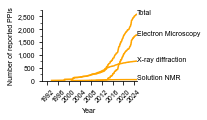

In [9]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.7, h=1.3)
xlow = np.datetime64('1990')
xhigh = np.datetime64('2024-12-31')
for method in i3d['experimental_method'].unique():
    if pd.isnull(method):
        continue
    x = list(sorted(i3d.loc[i3d['date'].notnull() &
                           (i3d['experimental_method'] == method), 'date'].values))
    y = list(range(1, 
              ((i3d['experimental_method'] == method)  &
                i3d['date'].notnull()).sum() + 1))
    x.append(xhigh)
    y.append(y[-1])
    ax.plot(x, y, color=COLOR_I3D)
    ax.text(x=xhigh, 
            y=(i3d['date'].notnull() & 
               (i3d['experimental_method'] == method)).sum(),
            s=method)
    
ax.plot(sorted(i3d.loc[i3d['date'].notnull(), 'date'].values),
        range(1, i3d['date'].notnull().sum() + 1),
        color=COLOR_I3D)
ax.text(x=xhigh, 
        y=(i3d['date'].notnull() ).sum(),
        s='Total')

ax.set_xlim(xlow, xhigh)
ax.set_xlabel('Year')
ax.xaxis.set_tick_params(rotation=45)
ax.set_ylabel('Number of reported PPIs')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0., 2750)
ax.set_yticks(range(0, 2751, 500))
ax.set_yticks(range(0, 2751, 250), minor=True)
ax.set_yticklabels(['{:,}'.format(y) for y in ax.get_yticks()])
savefig('lineplot_time_i3d_by-method_inc-total')

In [10]:
ayc['dataset_assigned'] = np.nan
ayc.loc[ayc['PDB_ID'].notnull(), 'dataset_assigned'] = 'I3D-exp-20'
ayc.loc[ayc['n_evidence'].notnull(), 'dataset_assigned'] = 'Lit-BM-24'
ayc.loc[(ayc['Uetz-screen'] == True) | (ayc['Ito-core'] == True) | (ayc['CCSB-YI1'] == True), 'dataset_assigned'] = 'Y2H-union'
ayc.loc[ayc['PPI Score'].notnull(), 'dataset_assigned'] = 'Alphafold-RoseTTAFold-core'
ayc.loc[ayc['dataset_assigned'].isnull() & (ayc['YeRI'] == True), 'dataset_assigned'] = 'YeRI'
if ayc['dataset_assigned'].isnull().any():
    raise UserWarning('bug in code')
print(ayc['dataset_assigned'].value_counts(dropna=False))

Lit-BM-24                     5673
Y2H-union                     2426
I3D-exp-20                    1657
YeRI                          1517
Alphafold-RoseTTAFold-core     329
Name: dataset_assigned, dtype: int64


# Yeast binary interactome size estimates

### Yu *et al.*, Science 2008

Page 107:
> we estimated that the yeast binary interactome consists of ~18,000 +- 4500 interactions (SOM VI)

From SOM VI it would appear the +/- refers to the 95% CI

### Stumpf *et al.*, 

Page 6963:
> "The results for the S. cerevisiae PIN suggest that it will ultimately contain 25,000–35,000 interactions (see also Table 1); this agrees well with previous estimates (22, 23). It also agrees well with estimates obtained from the recent data generated by Reguly et al. (15): for the pure literature-curated set we obtained 37,000 interactions; for the complete network data we obtained an estimate of 35,000 interactions in the yeast PIN. These two datasets were, however, collected from the literature and the sampling process is thus much harder, perhaps even impossible, to model accurately. "

All of the Reguly et al numbers refer to that dataset not the ones studied in the paper. The 25,000-35,000 appears to ignore the Ito et al numbers.

Use the Uetz numbers from Table 1: 28,472 - 26,650–30,460 (95%CI)

### Sambourg & Thierry-Mieg, BMC Bioinformatics 2010

Page 6:
> Taken together, this allows to estimate the size of the binary yeast interac- tome at ~ 37,600 interactions (95% confidence inter- val: 32252-43472, constructed with the normal approximation method [31]). Details on the calculation are provided in Methods.

### Grigoriev, NAR 2003

He reports 16,000 - 26,000, which comes from an average degree of 5 calculating after removing hubs or 8 if you leave the hubs.   
Replacing his number of yeast proteins of 6,300 with ours of 5,883, we get 15,000 - 24,000. This is not a 95%CI. There is also no central value, so we just take the middle. Homomers are not included in this estimate.

In [11]:
# From reading the papers, it appears the Stumpf estimate does not include self interactions
# but the Yu and Sambourg estimates do
n_total_interactions = {'Stumpf et al.': len(set(abbi.index)),
                        'Yu et al.': len(set(abbi_inc_homo.index)),
                        'Sambourg et al.': len(set(abbi_inc_homo.index)),
                        'Grigoriev': len(set(abbi.index))}
size = {
      'Grigoriev': 19500,
      'Stumpf et al.': 28472,
        'Yu et al.': 18000,
        'Sambourg et al.': 37600
        }
ci = {
    'Grigoriev': (15000, 24000),
    'Stumpf et al.': (26650, 30460),
      'Yu et al.': (13500, 22500),
      'Sambourg et al.': (32252, 43472),
      }

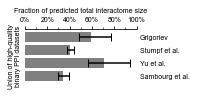

In [12]:
# From reading the papers, it appears the Stumpf estimate does not include self interactions
# but the Yu and Sambourg estimates do

binary_union = (set(abbi.index)
                .union(set(lit.index))
                .union(set(afrf.index))
                .union(set(i3d.index)))
binary_union_inc_homo = (set(abbi_inc_homo.index)
                .union(set(lit_inc_homo.index))
                .union(set(afrf.index))
                .union(set(i3d_inc_homo.index)))

n_total_interactions = {
    'Grigoriev': len(binary_union),
    'Stumpf et al.': len(binary_union),
    'Yu et al.': len(binary_union_inc_homo),
    'Sambourg et al.': len(binary_union_inc_homo),
                        }
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2, 1.)
ax.barh(list(size.keys()),
        [n / x for n, x in zip(n_total_interactions.values(), size.values())],
        color='grey')
ax.errorbar(y=list(ci.keys()),
            x=[n / x for n, x in zip(n_total_interactions.values(), size.values())],
            xerr=[[n * (1 / avrg - 1 / lims[1]) for n, lims, avrg in zip(n_total_interactions.values(), ci.values(), size.values())],
                  [n * (1 / lims[0] - 1 / avrg) for n, lims, avrg in zip(n_total_interactions.values(), ci.values(), size.values())]],
            color='black',
            fmt='none',
            capsize=4)
ax.set_xlim(0, 1)
ax.set_ylim(reversed(ax.get_ylim()))
ax.set_xticks([i / 5 for i in range(6)])
ax.set_xticks([(i + 0.5) / 5 for i in range(5)], minor=True)
ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.tick_top()
ax.yaxis.tick_right()
ax.set_ylabel('Union of high-quality\nbinary PPI datasets')
ax.set_xlabel('Fraction of predicted total interactome size')
ax.xaxis.set_label_position('top')
savefig('estimated-interactome-coverage_union')

In [13]:
len(binary_union)

11602

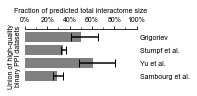

In [14]:
# From reading the papers, it appears the Stumpf estimate does not include self interactions
# but the Yu and Sambourg estimates do

binary_union = (set(y2h_union.index)
                .union(set(lit.index))
                .union(set(i3d.index)))
binary_union_inc_homo = (set(y2h_union_inc_homo.index)
                .union(set(lit_inc_homo.index))
                .union(set(i3d_inc_homo.index)))

n_total_interactions = {
    'Grigoriev': len(binary_union),
    'Stumpf et al.': len(binary_union),
    'Yu et al.': len(binary_union_inc_homo),
    'Sambourg et al.': len(binary_union_inc_homo),
                        }
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2, 1.)
ax.barh(list(size.keys()),
        [n / x for n, x in zip(n_total_interactions.values(), size.values())],
        color='grey')
ax.errorbar(y=list(ci.keys()),
            x=[n / x for n, x in zip(n_total_interactions.values(), size.values())],
            xerr=[[n * (1 / avrg - 1 / lims[1]) for n, lims, avrg in zip(n_total_interactions.values(), ci.values(), size.values())],
                  [n * (1 / lims[0] - 1 / avrg) for n, lims, avrg in zip(n_total_interactions.values(), ci.values(), size.values())]],
            color='black',
            fmt='none',
            capsize=4)
ax.set_xlim(0, 1)
ax.set_ylim(reversed(ax.get_ylim()))
ax.set_xticks([i / 5 for i in range(6)])
ax.set_xticks([(i + 0.5) / 5 for i in range(5)], minor=True)
ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.tick_top()
ax.yaxis.tick_right()
ax.set_ylabel('Union of high-quality\nbinary PPI datasets')
ax.set_xlabel('Fraction of predicted total interactome size')
ax.xaxis.set_label_position('top')
savefig('estimated-interactome-coverage_union_no-AI-pre-YeRI')

In [15]:
print(len(binary_union), len(binary_union_inc_homo))

9817 10905


[19500 28472 18000 37600]
[2295.960556160943, 1014.304352366212, 2295.960556160943, 2995.973419061568]
25892.985145666735 14434.697589999962


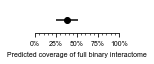

In [16]:
var = []
n_sigma_in_95ci = stats.norm.ppf(0.975)  # ~1.96
for estimate in size.keys():
    var.append(
        (ci[estimate][1] - size[estimate]) / n_sigma_in_95ci
    )
print(np.array(list(size.values())))
print(var)
res = combine_effects(effect=np.array(list(size.values())), variance=np.array(var))
avrg_size = res.mean_effect_re
avrg_ci = (res.mean_effect_re - res.conf_int(use_t=True, alpha=0.05)[3][0])
print(avrg_size, avrg_ci)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.5, h=0.5)
n_ppis = n_total_interactions['Grigoriev']

[[n_ppis * (1 / avrg_size - 1 / avrg_ci)] ,
  [n_ppis * (1 / avrg_ci - 1 / avrg_size)]]

ax.errorbar(y=[0], 
            x=[(n_ppis / avrg_size)],
            xerr=[n_ppis/avrg_size - n_ppis / (avrg_size + avrg_ci)],
            color='black',
            fmt='o'
            )
ax.set_xlim(0, 1)
ax.set_xticks([i / 4 for i in range(5)])
ax.set_xticks([i / 20 for i in range(21)], minor=True)
ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_tick_params(length=0)
#ax.xaxis.tick_top()
ax.yaxis.tick_right()
ax.set_yticks([])
ax.set_xlabel('Predicted coverage of full binary interactome')
#ax.xaxis.set_label_position('top')
savefig('estimated-interactome-coverage_union_no-AI-pre-YeRI_single-combined')

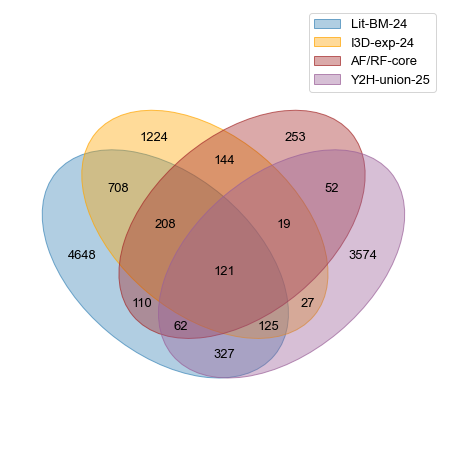

In [17]:
venn({
      'Lit-BM-24': set(lit.index),
      'I3D-exp-24': set(i3d.index),
      'AF/RF-core': set(afrf.index),
      'Y2H-union-25': set(abbi.index)
      },
      cmap=[COLOR_LIT, COLOR_I3D, COLOR_ALPHAFOLD_ROSETTAFOLD, COLOR_Y2H])
plt.savefig('../figures/venn_edges_litbm_i3d_abbi_alphafoldrosettafold-core.pdf',
            bbox_inches='tight')

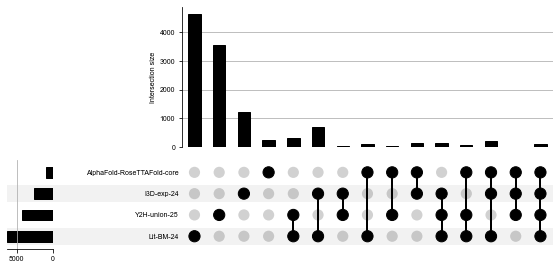

In [18]:
overlaps = pd.DataFrame(index=list(set(lit.index)
                             .union(set(i3d.index))
                             .union(set(afrf.index))
                             .union(set(abbi.index))))
overlaps['I3D-exp-24'] = overlaps.index.isin(i3d.index)
overlaps['Lit-BM-24'] = overlaps.index.isin(lit.index)
overlaps['AlphaFold-RoseTTAFold-core'] = overlaps.index.isin(afrf.index)
overlaps['Y2H-union-25'] = overlaps.index.isin(abbi.index)
upsetplot.plot(overlaps.groupby(list(overlaps.columns)).size())
plt.savefig('../figures/high-quality-binary-union_UpSet.pdf',
            bbox_inches='tight')

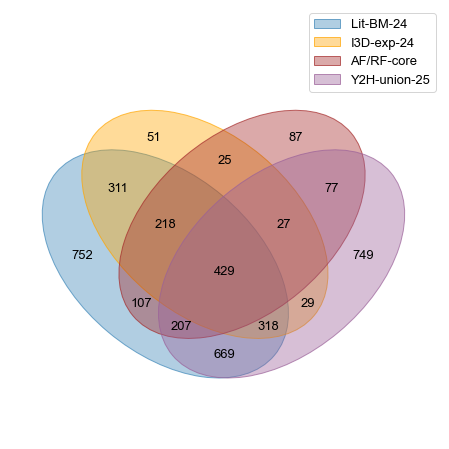

In [19]:
venn({'Lit-BM-24': set(lit['orf_name_a']).union(set(lit['orf_name_b'])),
      'I3D-exp-24': set(i3d['orf_name_a']).union(set(i3d['orf_name_b'])),
      'AF/RF-core': set(afrf['orf_name_a']).union(set(afrf['orf_name_b'])),
      'Y2H-union-25': set(abbi['orf_name_a']).union(set(abbi['orf_name_b']))
      },
      cmap=[COLOR_LIT, COLOR_I3D, COLOR_ALPHAFOLD_ROSETTAFOLD, COLOR_Y2H])
plt.savefig('../figures/venn_nodes_litbm_i3d_abbi_afrf.pdf', bbox_inches='tight')

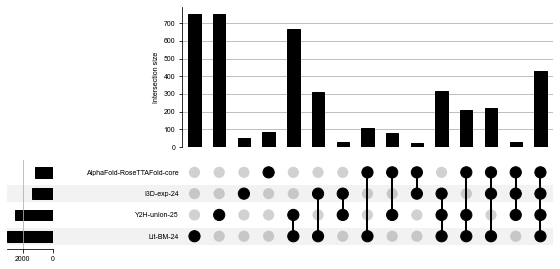

In [20]:
lit_nodes = set(lit['orf_name_a']).union(set(lit['orf_name_b']))
i3d_nodes = set(i3d['orf_name_a']).union(set(i3d['orf_name_b']))
afrf_nodes = set(afrf['orf_name_a']).union(set(afrf['orf_name_b']))
abbi_nodes = set(abbi['orf_name_a']).union(set(abbi['orf_name_b']))

overlaps = pd.DataFrame(index=list(lit_nodes
                             .union(i3d_nodes)
                             .union(afrf_nodes)
                             .union(abbi_nodes)))
# NOTE: matching order of maps to previous plot
overlaps['Lit-BM-24'] = overlaps.index.isin(lit_nodes)
overlaps['Y2H-union-25'] = overlaps.index.isin(abbi_nodes)
overlaps['I3D-exp-24'] = overlaps.index.isin(i3d_nodes)
overlaps['AlphaFold-RoseTTAFold-core'] = overlaps.index.isin(afrf_nodes)
upsetplot.plot(overlaps.groupby(list(overlaps.columns)).size(),
               sort_categories_by='input')
plt.savefig('../figures/high-quality-binary-union_nodes_UpSet.pdf',
            bbox_inches='tight')

In [21]:
orfs_with_hqb = (set(lit['orf_name_a']).union(set(lit['orf_name_b']))
                .union(
                set(i3d['orf_name_a']).union(set(i3d['orf_name_b']))
                ).union(
                set(afrf['orf_name_a']).union(set(afrf['orf_name_b']))
                ).union(
                set(abbi['orf_name_a']).union(set(abbi['orf_name_b']))
                ))
print(len(orfs_with_hqb), 'unique ORFs in high-quality binary PPI datasets')

4056 unique ORFs in high-quality binary PPI datasets
